# Counterfactual Transportability

This notebook is a demonstration of identification algorithms for counterfactual transportability from Correa, Lee, and Bareinboim's 2022 paper, [Counterfactual Transportability: A Formal Approach](https://proceedings.mlr.press/v162/correa22a/correa22a.pdf). These algorithms determine whether a causal question can be identified and if so, they return a probabilistic expression for how to estimate an answer to that causal question.

The power of transportability lies in the fact that if we can't identify a causal question in one setting due to a lack of experimental data, we can sometimes bridge the gap and infer the causal relationship anyway using an experiment from a different setting. This notebook shows how to fit such models _unconditional_ and _conditional_ transportability models.

### Road map for this notebook

1. We introduce an example experimental setting that would use counterfactual transportability.
2. We give a simple example of using this package to identify an unconditional causal question.
3. We modify that simple example to specify a conditional causal question and identify it.
4. We introduce an example with a slightly more complex graph that demonstrates bringing together information from multiple experiments in multiple settings.
5. We identify an unconditional causal question for that more complex example, and briefly identify a conditional question as well.

A separate, "advanced" notebook provides more advanced discussions of how to use the debugger to understand what is happening under the hood, and discusses some of the error messages intended to make using the tool easy.

In [1]:
from y0.algorithm.counterfactual_transport.api import (
    CFTDomain,
    conditional_cft,
    unconditional_cft,
)
from y0.algorithm.identify import identify_outcomes
from y0.algorithm.transport import transport_variable
from y0.dsl import (
    P,
    Variable,
)
from y0.graph import NxMixedGraph

## Motivating example

Suppose in a study of vaccine efficacy we're interested in the causal effect of vaccination on being severely infected with COVID. 
For purposes of simplicy, $V$ (_Vaccinated_) represents whether a person was _vaccinated_ or not, $A$ (_Antibody_) represents the their antibody biomarker response to the vaccine, and $I$ (_Infected_) represents whether they test positive for COVID-19. All three of these variables are binary variables, such that $+$ refers to `True` and $-$ refers to `False`.


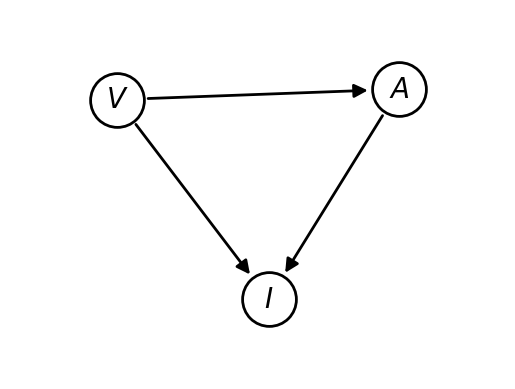

In [2]:
Vaccinated = Variable("V")
Antibody = Variable("A")
Infected = Variable("I")

simple_covid_graph = NxMixedGraph.from_edges(
    directed=[
        (Vaccinated, Antibody),
        (Antibody, Infected),
        (Vaccinated, Infected),
    ],
)
simple_covid_graph.draw()

Thanks to an implementation of Shpitser's ID algorithm in $Y_0$, we can estimate the total effect of _Vaccinated_ on _Infected_:

In [3]:
identify_outcomes(simple_covid_graph, treatments={Vaccinated}, outcomes={Infected})

Sum[A](P(A | V) * P(I | A, V))

This model is too simplistic, because many unmeasured factors affect both an individual's choice to be vaccinated and their antibody levels. Let's represent those unmeasured factors, "confounders", by a bi-directed edge between Vaccinated and Antibody response, say age, that affects both the likelihood of choosing vaccination and the strength of their antibody response.

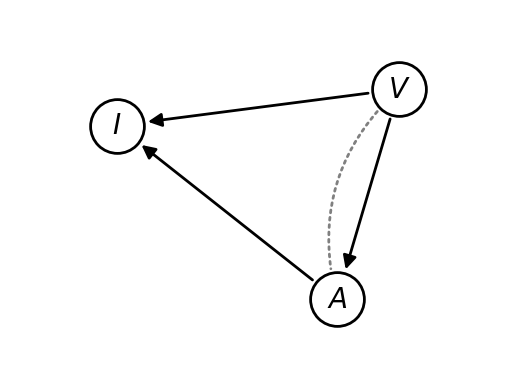

In [4]:
covid_with_confounders_graph = NxMixedGraph.from_edges(
    directed=[
        (Vaccinated, Antibody),
        (Antibody, Infected),
        (Vaccinated, Infected),
    ],
    undirected=[(Antibody, Vaccinated)],
)
covid_with_confounders_graph.draw()

The effect of _Vaccinated_ on _Infected_ is not identifiable due to the confounder between _Vaccinated_ and _Antibody_:

In [5]:
identify_outcomes(
    covid_with_confounders_graph, treatments={Vaccinated}, outcomes={Infected}
) is None

True

### An Unconditional Counterfactual Transportability Model

Let's add more confounders to the graph, and despite those additional confounders we'll be able to use an experiment from another setting to identify the causal question using the counterfactual transportability algorithms from [Counterfactual Transportability: A Formal Approach](https://proceedings.mlr.press/v162/correa22a/correa22a.pdf). 

Consider an observational study in the United States. We assume that an unobserved confounder (like age) can affect both the likelihood of choosing to receive a vaccine and mounting a high antibody response. We also assume that there may be some unobserved confounders (such as conscientiousness) that affect the likelihood of choosing vaccination and the likelihood of avoiding infection. 

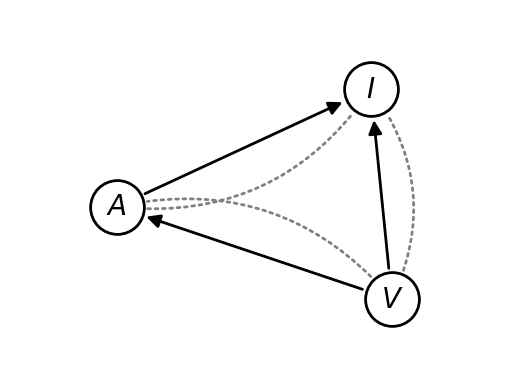

In [6]:
USA = Variable("USA")

# This graph represents the target domain, the United States.
observational_study_in_usa_graph = NxMixedGraph.from_edges(
    directed=[
        (Vaccinated, Antibody),
        (Antibody, Infected),
        (Vaccinated, Infected),
    ],
    undirected=[(Vaccinated, Antibody), (Vaccinated, Infected), (Antibody, Infected)],
)
observational_study_in_usa_graph.draw()

Suppose we want to know the likelihood that a person would be infected had they been made to not be vaccinated  $P_{do(V=0)}(I=1)$. That would be represented in $Y_0$ as follows:

In [7]:
effect_of_vaccination = P(+Infected @ -Vaccinated)
display(effect_of_vaccination)

P[V](+I)

Given that the model is not identified with just one bi-directed edge, surely it is not identified if we add another two -- but let's confirm that.

In [8]:
identify_outcomes(
    observational_study_in_usa_graph, treatments={Vaccinated}, outcomes={Infected}
) is None

True

Now, let's assume we have a vaccine efficacy study in Australia in which people were randomly assigned to receive vaccine or placebo, and the effect on infection was observed. In this population, there were some factors that could not be controlled (such as health status) that affected both the strength of the antibody response and the likelihood of being infected.  Moreover, suppose the distribution of people who are vaccinated in Australia is different than in the United States due to cultural differences. We denote this difference with a "transportability node" $T_V$ as per the notation in the paper.

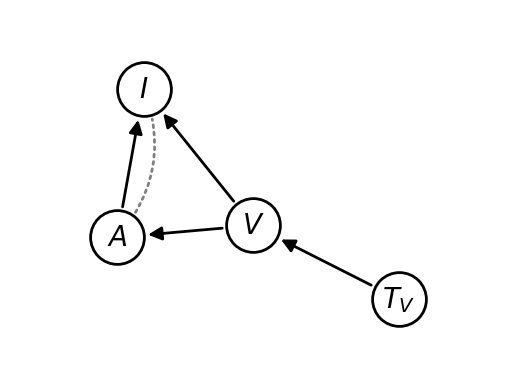

In [9]:
Australia = Variable("AUS")

vaccine_efficacy_in_australia_graph = NxMixedGraph.from_edges(
    directed=[
        (Vaccinated, Antibody),
        (Vaccinated, Infected),
        (Antibody, Infected),
        (transport_variable(Vaccinated), Vaccinated),
    ],
    undirected=[(Antibody, Infected)],
)
vaccine_efficacy_in_australia_graph.draw()

Now we combine the observational study in the US with the randomized study in Australia to identify the effect of vaccination on the vaccinated in the USA. We can estimate the effect using the unconditional counterfactual transportability algorithm in $Y_0$. To compute this, we need to specify the _domains_ for each setting -- that is, the observational study in the USA and the randomized trial in Australia. When specifying each domain via $Y_0$'s API, we pass as parameters a label (the `population` parameter), the corresponding `graph`, and we indicate the set of `policy_variables` (variables on which experimenters have intervened in some way). The US study has no policy variables because it's an observational study.

In [10]:
domains = [
    CFTDomain(
        population=Australia,
        graph=vaccine_efficacy_in_australia_graph,
        policy_variables={Vaccinated},
    ),
    CFTDomain(
        population=USA,
        graph=observational_study_in_usa_graph,
    ),
]

Next we specify the causal query $I_{do(V=-v)}=+i$ as an `event`, and then fit the model using a call to `unconditional_cft()`. 

In [11]:
event = [(+Infected @ -Vaccinated)]
unconditional_cft_result = unconditional_cft(
    event=event, target_domain_graph=observational_study_in_usa_graph, domains=domains
)
unconditional_cft_result.expression

Sum[A](PP[AUS](A | V) * PP[AUS](I | V, A))

Here we have specified our causal query (the probability that a person would be infected in a world in which they were made to not be vaccinated) as an `event`, and passed that event to the `unconditional_cft` algorithm. We also specify the graph on which we're drawing inferences as the `target_domain_graph`, and pass in the domains that we're using to draw inferences to the algorithm as well.

The algorithms in Correa, Lee, and Bareinboim's paper give us a way to use the Australia experiment to make causal inferences about the United States. Such a powerful tool can save time and money for researchers, practitioners, and policy makers.

Next, let's move on to a conditional query.

### An Conditional Counterfactual Transportability Model

For the next example, we add a variable to the graph to have a complex enough graph to demonstrate a case where a causal question that conditions on a counterfactual variable requires transporting the solution from an experiment in another setting.

Let's say that whether a person gets vaccinated is also determined by their social environment, such as neighborhood effects. That is, a person's _neighborhood_ (_N_) affects their own likelihood to get a vaccine, but does not directly affect the severity of their infection or their antibody response. Unobserved additional social factors may impact both the choice of neighborhood and a person's own vaccination decision. 

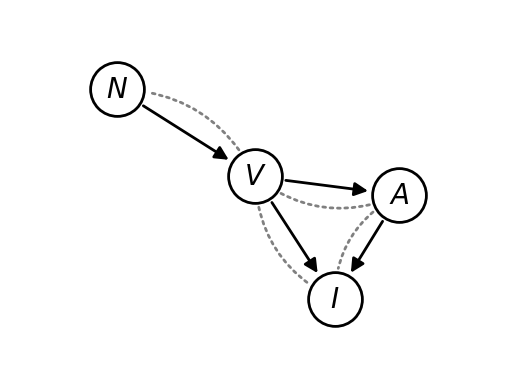

In [12]:
Neighborhood = Variable("N")

# This graph represents the target domain, the United States.
observational_study_in_usa_graph_2 = NxMixedGraph.from_edges(
    directed=[
        (Vaccinated, Antibody),
        (Antibody, Infected),
        (Vaccinated, Infected),
        (Neighborhood, Vaccinated),
    ],
    undirected=[
        (Vaccinated, Antibody),
        (Vaccinated, Infected),
        (Antibody, Infected),
        (Neighborhood, Vaccinated),
    ],
)
observational_study_in_usa_graph_2.draw()

Suppose we want to know the effect of a policy to get everyone vaccinated on the COVID status of people who were made to live in a particular neighborhood (such as people assigned to a homeless shelter). That is, we want to know the effect of a policy $I_{do(V = +v)}$ given the counterfactual variable $V_{do(N = -n)}$. That would be represented in $Y_0$ as follows:

In [13]:
effect_of_vaccination_on_neighborhood = P(+Infected @ +Vaccinated | +Vaccinated @ -Neighborhood)
display(effect_of_vaccination_on_neighborhood)

P(+I @ +V | +V @ -N)

Let's say we have a data set from Australia in which the distribution of neighborhoods is different than in the United States (say, the neighborhoods are homeless shelters instead of census blocks), and where there's been an experiment randomly assigning people to those shelters (eliminating the confounded relationship between _Neighborhood_ and _Vaccinated_). 

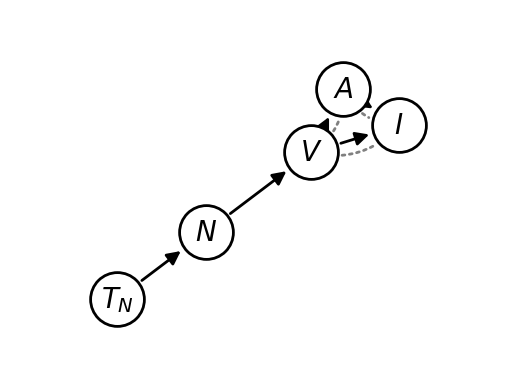

In [14]:
vaccine_efficacy_in_australia_graph_2 = NxMixedGraph.from_edges(
    directed=[
        (Vaccinated, Antibody),
        (Vaccinated, Infected),
        (Antibody, Infected),
        (transport_variable(Neighborhood), Neighborhood),
        (Neighborhood, Vaccinated),
    ],
    undirected=[(Antibody, Infected), (Antibody, Vaccinated), (Infected, Vaccinated)],
)
vaccine_efficacy_in_australia_graph_2.draw()

We respecify the domains, noting the intervention on _Neighborhood_ for Australia:

In [15]:
domains2 = [
    CFTDomain(
        population=USA,
        graph=observational_study_in_usa_graph_2,
    ),
    CFTDomain(
        population=Australia,
        graph=vaccine_efficacy_in_australia_graph_2,
        policy_variables={Neighborhood},
    ),
]

The conditional query is run with a call to `conditional_cft`:

In [16]:
conditional_cft_result = conditional_cft(
    outcomes=[+Infected @ +Vaccinated],
    conditions=[+Vaccinated @ -Neighborhood],
    target_domain_graph=observational_study_in_usa_graph_2,
    domains=domains2,
)

conditional_cft_result.expression

((Sum[A](PP[AUS](A | V, N) * PP[AUS](I | V, A, N) * PP[AUS](V | N)) / Sum[A, I](PP[AUS](A | V, N) * PP[AUS](I | V, A, N) * PP[AUS](V | N))))

In this case, the USA graph is not identifiable, and the Australia graph is necessary to fit the model. The "Advanced Features" notebook contains an explanation of what happens here that re-runs this model with debugging features enabled.

Next, we look at an example of transporting information from multiple source domains to resolve a single counterfactual query in the target domain.

### Example of using information from multiple settings to arrive at a single counterfactual inference: mandatory vaccination and infection severity management

Consider a scenario in which the United States is considering imposing a two-pronged policy combining mandatory vaccination with **a program to reduce infection severity for COVID-positive patients with low antibody levels.** Let us add another outcome variable: whether a person survived, affected directly by infection severity and vaccination status (allowing for the purpose of pedagogy here that in rare cases a vaccine could actually cause people to die). Other factors such as whether a person is immunocompromised may affect both infection severity and survival. **[Why does vaccination directly affect survival?]**. A graph before the policy intervention might look like the following:

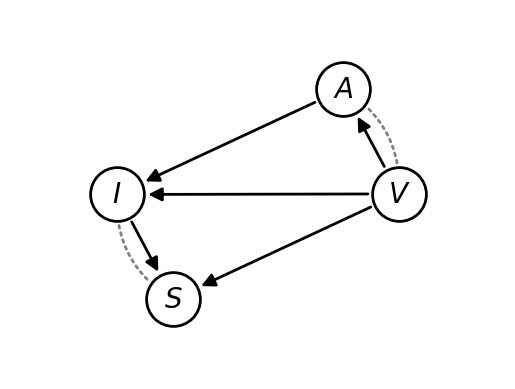

In [17]:
# Based on [correa20a]_, Figure 1.
USA_population = Variable(r"\text{USA}")
Vaccinated = Variable("V")
Antibody = Variable("A")
Infected = Variable("I")
Survived = Variable("S")

USA_graph = NxMixedGraph.from_edges(
    directed=[
        (Vaccinated, Antibody),
        (Vaccinated, Infected),
        (Antibody, Infected),
        (Vaccinated, Survived),
        (Infected, Survived),
    ],
    undirected=[(Vaccinated, Antibody), (Infected, Survived)],
)
USA_graph.draw()

In this graph, vaccination affects the amount of antibody production. An unobserved confounder (like age) can affect both the likelihood of choosing to receive a vaccine and mounting a high antibody response, hence the bidirected edge between $V$ and $A$. Infection severity and vaccination directly affect whether a person survived, and other factors such as whether a person is immunocompromised affect both infection severity and survival. **[Why does vaccination directly affect survival?]**

Suppose that Washington DC wants to know the effect of a mandatory vaccination policy on survival $S_{do(V = +v)}$. In addition to vaccinating everyone (removing the bidirected edge between Vaccination and the Antibody response), **it would intervene to provide additional therapy to reduce severe infection by monitoring the antibody response and intervening if that response is not strong enough.** This _stochastic_ intervention retains the edge from `Antibody` to `Infected` while removing the bidirected edge between `Infected` and `Survived`. It would therefore look as follows:

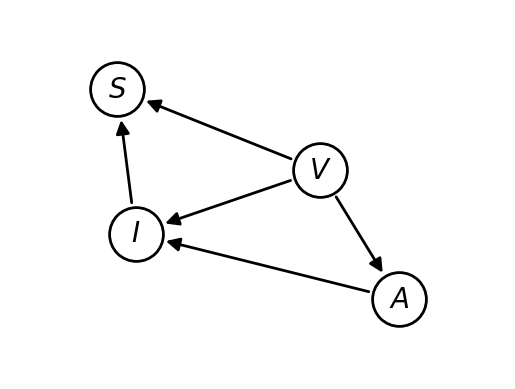

In [18]:
USA_graph_under_policy = NxMixedGraph.from_edges(
    directed=[
        (Vaccinated, Antibody),
        (Vaccinated, Infected),
        (Antibody, Infected),
        (Vaccinated, Survived),
        (Infected, Survived),
    ],
)
USA_graph_under_policy.draw()

To do its forecasting, the United States government only has observational data from the US. Suppose that China, however, has already conducted experiments with mandatory vaccination and survival -- except that the timing of severe infection management was not a function of the antibody response but rather **a non-pharmaceutical intervention that has nothing to do with antibody response, such as social distancing, masking, or a lockdown.** Furthermore, the pandemic struck in China all at once compared to the United States, overwhelming city hospitals, so we represent survival with a transportability node:  

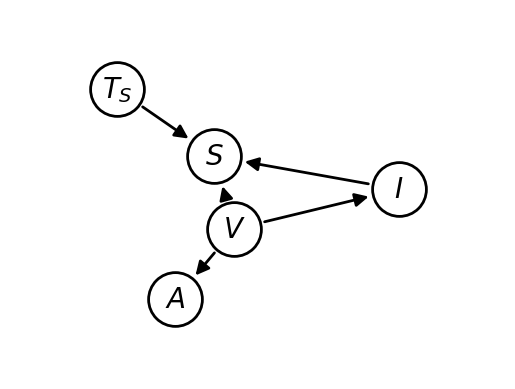

In [19]:
China_population = Variable(r"\text{China}")
China_graph = NxMixedGraph.from_edges(
    directed=[
        (Vaccinated, Antibody),
        (Vaccinated, Infected),
        (Vaccinated, Survived),
        (Infected, Survived),
        (transport_variable(Survived), Survived),
    ],
)
China_graph.draw()

Finally, we have data from a COVID experiment in South Africa in which people received therapy whenever their antibody levels were low, but which did not involve the imposition of a mandatory vaccination program. **South Africa may have had a different prevalence of prior exposure to COVID at the time of the experiment (perhaps due to a different history of virus strains), so the immune response to the presence of the virus was different in South Africa compared to China and the US and we attach a transportability node to the `Antibody` variable.** Additionally, the absence of the mandatory vaccine implies that the bidirectional edge between `Vaccinated` and `Antibody` due to unobserved confounding variables such as age remains. 

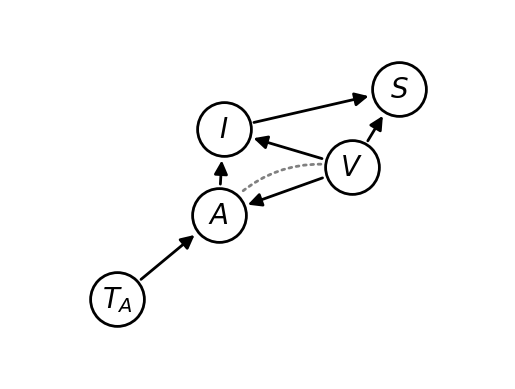

In [20]:
South_Africa_population = Variable(r"\text{SA}")
South_Africa_graph = NxMixedGraph.from_edges(
    directed=[
        (Vaccinated, Antibody),
        (Antibody, Infected),
        (Vaccinated, Infected),
        (Vaccinated, Survived),
        (Infected, Survived),
        (transport_variable(Antibody), Antibody),
    ],
    undirected=[(Vaccinated, Antibody)],
)
South_Africa_graph.draw()

Suppose the United States would like to know **how many people would have survived COVID were it to have implemented a manditory vaccination strategy and additional therapy to mitigate infection severity depending on the level of antibody responses.** We frame an unconditional counterfactual query:

In [21]:
effect_of_do_vaccination_query = -Survived @ -Vaccinated

do_vaccination_domains = [
    CFTDomain(
        population=USA_population,
        graph=USA_graph,
    ),
    CFTDomain(
        population=China_population,
        graph=China_graph,
        policy_variables={Vaccinated, Infected},
    ),
    CFTDomain(
        population=South_Africa_population,
        graph=South_Africa_graph,
        policy_variables={Infected},
    ),
]

do_vaccination_result = unconditional_cft(
    event=effect_of_do_vaccination_query,
    target_domain_graph=USA_graph_under_policy,
    domains=do_vaccination_domains,
)
do_vaccination_result.display()

P[V](-S)

Sum[A, I](PP[\text{China}](A | V) * PP[\text{SA}](S | V, I, A) * Sum[S](PP[\text{USA}](I | V, A) * PP[\text{USA}](S | V, I, A)))

We can also view the results of a query in an alternate form:

In [22]:
print(str(do_vaccination_result.expression))

Sum[A, I](PP[\text{China}](A | V) * PP[\text{SA}](S | V, I, A) * Sum[S](PP[\text{USA}](I | V, A) * PP[\text{USA}](S | V, I, A)))


We can see that the survival probability having value `-S`, given the vaccination strategy adjusted a person's vaccination status to `+V`, is identifiable and is a composite of experimental results from China and South Africa and observational data from the United States. Note that without the data from China and South Africa, the query is not identifiable:

In [23]:
effect_of_do_vaccination_query = -Survived @ -Vaccinated

do_vaccination_domains_us_only = [
    CFTDomain(
        population=USA_population,
        graph=USA_graph,
    ),
]

do_vaccination_result_us_only = unconditional_cft(
    event=effect_of_do_vaccination_query,
    target_domain_graph=USA_graph_under_policy,
    domains=do_vaccination_domains_us_only,
)
do_vaccination_result_us_only is None

True

Let us also specify a more targeted conditional query: **we would like to know the survival probability in a counterfactual world where the vaccination mandate had been implemented, for people who experienced severe infections (also affected by their getting a vaccine).**

In [24]:
conditional_do_vaccination_result = conditional_cft(
    outcomes=-Survived @ -Vaccinated,
    conditions=-Infected @ -Vaccinated,
    target_domain_graph=USA_graph_under_policy,
    domains=do_vaccination_domains,
)
conditional_do_vaccination_result.display()

P(-I, -S)

((PP[\text{SA}](S | V, I, A) / Sum[S](PP[\text{SA}](S | V, I, A))))

In [25]:
print(str(conditional_do_vaccination_result.expression))

((PP[\text{SA}](S | V, I, A) / Sum[S](PP[\text{SA}](S | V, I, A))))


In this case, the outcome is solely a function of the South Africa data.